<a href="https://colab.research.google.com/github/jkarthiknai/Hotel-Reviews-Classification/blob/main/Truthful_Deceptive_Hotel_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from transformers import RobertaTokenizer
from sklearn.model_selection import GridSearchCV
import transformers

In [ ]:
!pip install --upgrade transformers

In [ ]:
df =pd.DataFrame()
df = pd.read_csv('Hotel_Reviews_EDA.csv')
df1 = df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1600 non-null   int64  
 1   hotel_name              1600 non-null   object 
 2   review_text             1600 non-null   object 
 3   review_type             1600 non-null   object 
 4   polarity                1600 non-null   object 
 5   word_count              1600 non-null   int64  
 6   sentence_count          1600 non-null   int64  
 7   avgwordsper_sentence    1600 non-null   float64
 8   cleaned_text            1600 non-null   object 
 9   sentiment_polarity      1600 non-null   float64
 10  sentiment_subjectivity  1600 non-null   float64
 11  emotion                 1600 non-null   object 
 12  pos_counts              1600 non-null   object 
 13  entities                1600 non-null   object 
 14  pronouns                1600 non-null   

In [ ]:
import pandas as pd
from collections import Counter

# Convert the 'pos_counts' column from string to actual Counter objects if necessary
df1['pos_counts'] = df1['pos_counts'].apply(lambda x: eval(x, {'Counter': Counter}))  # Pass Counter to eval()

# Extract 'NUM' and 'PUNCT' counts and create separate columns
df1['pos_number'] = df1['pos_counts'].apply(lambda x: x.get('NUM', 0))
df1['pos_punct'] = df1['pos_counts'].apply(lambda x: x.get('PUNCT', 0))

# Drop the original 'pos_counts' column if no longer needed
# df1 = df1.drop(columns=['pos_counts'])

# Display the resulting DataFrame with 'num' and 'punct' columns
print(df1[['pos_number', 'pos_punct']].head())

   pos_number  pos_punct
0           5          0
1           1          0
2           0          1
3           0          1
4           5          3


In [ ]:
import pandas as pd
# Create new features based on specific pronouns
df1['pron_us'] = df1['pronouns'].apply(lambda x: x.count('us'))
df1['pron_anyone'] = df1['pronouns'].apply(lambda x: x.count('anyone'))

# Display the resulting DataFrame with 'pron_us' and 'pron_anyone' columns
print(df1[['pron_us', 'pron_anyone']].head())

   pron_us  pron_anyone
0        2            0
1        0            0
2        0            0
3        0            0
4        0            0


In [ ]:
import pandas as pd

# Create the new feature based on the occurrence of the action verb "staying"
df['av_staying'] = df['action_verbs'].apply(lambda x: x.count('staying'))

# Display the resulting DataFrame with the 'av_staying' column
print(df[['av_staying']].head())

   av_staying
0           0
1           0
2           0
3           0
4           0


In [ ]:
df1.columns

Index(['Unnamed: 0', 'hotel_name', 'review_text', 'review_type', 'polarity',
       'word_count', 'sentence_count', 'avgwordsper_sentence', 'cleaned_text',
       'sentiment_polarity', 'sentiment_subjectivity', 'emotion', 'pos_counts',
       'entities', 'pronouns', 'action_verbs', 'pos_number', 'pos_punct',
       'pron_us', 'pron_anyone', 'av_staying'],
      dtype='object')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1600 non-null   int64  
 1   hotel_name              1600 non-null   object 
 2   review_text             1600 non-null   object 
 3   review_type             1600 non-null   object 
 4   polarity                1600 non-null   object 
 5   word_count              1600 non-null   int64  
 6   sentence_count          1600 non-null   int64  
 7   avgwordsper_sentence    1600 non-null   float64
 8   cleaned_text            1600 non-null   object 
 9   sentiment_polarity      1600 non-null   float64
 10  sentiment_subjectivity  1600 non-null   float64
 11  emotion                 1600 non-null   object 
 12  pos_counts              1600 non-null   object 
 13  entities                1600 non-null   object 
 14  pronouns                1600 non-null   

In [ ]:
X_numerical = df1[['word_count', 'sentence_count', 'avgwordsper_sentence',
       'sentiment_polarity', 'sentiment_subjectivity','pos_number', 'pos_punct',
       'pron_us', 'pron_anyone', 'av_staying']]
print(X_numerical)

      word_count  sentence_count  avgwordsper_sentence  sentiment_polarity  \
0            962              10             96.200000            0.192500   
1            652              10             65.200000            0.326515   
2            317               6             52.833333            0.442593   
3            231               5             46.200000            0.633333   
4            322               6             53.666667           -0.166667   
...          ...             ...                   ...                 ...   
1595         836               7            119.428571            0.128333   
1596         699               6            116.500000            0.018333   
1597        1267              20             63.350000            0.057099   
1598         314               4             78.500000            0.020000   
1599        1393              12            116.083333            0.090789   

      sentiment_subjectivity  pos_number  pos_punct  pron_us  p

In [ ]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_numerical)
X_transformed = pd.DataFrame(X_transformed, columns=X_numerical.columns)
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   word_count              1600 non-null   float64
 1   sentence_count          1600 non-null   float64
 2   avgwordsper_sentence    1600 non-null   float64
 3   sentiment_polarity      1600 non-null   float64
 4   sentiment_subjectivity  1600 non-null   float64
 5   pos_number              1600 non-null   float64
 6   pos_punct               1600 non-null   float64
 7   pron_us                 1600 non-null   float64
 8   pron_anyone             1600 non-null   float64
 9   av_staying              1600 non-null   float64
dtypes: float64(10)
memory usage: 125.1 KB


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
emotion_encoded = encoder.fit_transform(df1[['emotion']])
emotion_columns = encoder.get_feature_names_out(['emotion'])
emotion_encoding = pd.DataFrame(emotion_encoded, columns=emotion_columns)

encoder = OneHotEncoder(sparse_output=False)
polarity_encoded = encoder.fit_transform(df1[['polarity']])
polarity_columns = encoder.get_feature_names_out(['polarity'])
polarity_encoding = pd.DataFrame(polarity_encoded, columns=polarity_columns)

In [ ]:
df1.columns

Index(['Unnamed: 0', 'hotel_name', 'review_text', 'review_type', 'polarity',
       'word_count', 'sentence_count', 'avgwordsper_sentence', 'cleaned_text',
       'sentiment_polarity', 'sentiment_subjectivity', 'emotion', 'pos_counts',
       'entities', 'pronouns', 'action_verbs', 'pos_number', 'pos_punct',
       'pron_us', 'pron_anyone', 'av_staying'],
      dtype='object')

In [ ]:
review_text_type=pd.DataFrame(df1[['review_text', 'review_type']],columns=['review_text','review_type'])
df2=pd.concat([X_transformed, emotion_encoding, polarity_encoding, review_text_type], axis=1)

In [ ]:
df2=df2.drop(columns=['pron_anyone', 'av_staying'])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   word_count              1600 non-null   float64
 1   sentence_count          1600 non-null   float64
 2   avgwordsper_sentence    1600 non-null   float64
 3   sentiment_polarity      1600 non-null   float64
 4   sentiment_subjectivity  1600 non-null   float64
 5   pos_number              1600 non-null   float64
 6   pos_punct               1600 non-null   float64
 7   pron_us                 1600 non-null   float64
 8   emotion_Anger           1600 non-null   float64
 9   emotion_Fear            1600 non-null   float64
 10  emotion_Joy             1600 non-null   float64
 11  emotion_Neutral         1600 non-null   float64
 12  emotion_Trust           1600 non-null   float64
 13  polarity_negative       1600 non-null   float64
 14  polarity_positive       1600 non-null   

In [ ]:
df2['target'] = df2['review_type'].map({'truthful': 0, 'deceptive': 1})
df2['target'].value_counts()

,count
target,
0,800
1,800


In [ ]:
df2.columns

Index(['word_count', 'sentence_count', 'avgwordsper_sentence',
       'sentiment_polarity', 'sentiment_subjectivity', 'pos_number',
       'pos_punct', 'pron_us', 'emotion_Anger', 'emotion_Fear', 'emotion_Joy',
       'emotion_Neutral', 'emotion_Trust', 'polarity_negative',
       'polarity_positive', 'review_text', 'review_type', 'target'],
      dtype='object')

In [ ]:
df2[['polarity_negative','polarity_positive']].value_counts()

,,count
polarity_negative,polarity_positive,
0.0,1.0,800
1.0,0.0,800


In [ ]:
!pip install transformers torch

In [ ]:
train_df, temp_df = train_test_split(df2, test_size=0.25, stratify=df2['target'], random_state=73)

# Split the temp_df into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=73)

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text data
train_encodings = tokenizer(train_df['review_text'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['review_text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['review_text'].tolist(), truncation=True, padding=True)

# Convert the labels to a list
train_labels = train_df['target'].tolist()
val_labels = val_df['target'].tolist()
test_labels = test_df['target'].tolist()

In [ ]:
#train_encodings.keys()

In [ ]:
test_df.columns

Index(['word_count', 'sentence_count', 'avgwordsper_sentence',
       'sentiment_polarity', 'sentiment_subjectivity', 'pos_number',
       'pos_punct', 'pron_us', 'emotion_Anger', 'emotion_Fear', 'emotion_Joy',
       'emotion_Neutral', 'emotion_Trust', 'polarity_negative',
       'polarity_positive', 'review_text', 'review_type', 'target'],
      dtype='object')

In [ ]:
import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, dataframe, labels):
        self.encodings = encodings
        self.labels = labels
        self.dataframe = dataframe

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        # Access the correct columns using self.dataframe.columns instead of test_df.columns
        features = self.dataframe.iloc[idx][self.dataframe.columns].values
        item['additional_features'] = torch.tensor(features, dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 1415 to 1377
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   word_count              1200 non-null   float64
 1   sentence_count          1200 non-null   float64
 2   avgwordsper_sentence    1200 non-null   float64
 3   sentiment_polarity      1200 non-null   float64
 4   sentiment_subjectivity  1200 non-null   float64
 5   pos_number              1200 non-null   float64
 6   pos_punct               1200 non-null   float64
 7   pron_us                 1200 non-null   float64
 8   emotion_Anger           1200 non-null   float64
 9   emotion_Fear            1200 non-null   float64
 10  emotion_Joy             1200 non-null   float64
 11  emotion_Neutral         1200 non-null   float64
 12  emotion_Trust           1200 non-null   float64
 13  polarity_negative       1200 non-null   float64
 14  polarity_positive       1200 non-null   fl

In [ ]:
# Create dataset objects for training, validation, and testing
train_dataset = ReviewDataset(train_encodings, train_df.drop(columns=['review_text','review_type','target']), train_labels)
val_dataset = ReviewDataset(val_encodings, val_df.drop(columns=['review_text','review_type','target']), val_labels)
test_dataset = ReviewDataset(test_encodings, test_df.drop(columns=['review_text','review_type','target']), test_labels)

In [ ]:
type(test_dataset)

__main__.ReviewDataset

In [ ]:
import transformers
print(transformers.__version__)

4.53.0


In [ ]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from transformers import RobertaForSequenceClassification, RobertaConfig
from transformers import get_cosine_schedule_with_warmup
from transformers.trainer_callback import TrainerCallback

config = RobertaConfig.from_pretrained('roberta-base',
                                       hidden_dropout_prob=0.15,
                                       attention_probs_dropout_prob=0.18)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=350,
    weight_decay=0.029,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=0.000065,
    save_total_limit=2,
    load_best_model_at_end=True
)

# Define early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001)

# Initialize Trainer with early stopping and custom scheduler
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping]
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.686000,0.676325
2,0.396800,0.311672
3,0.381800,0.728116
4,0.512900,0.342640


TrainOutput(global_step=300, training_loss=0.4663028824329376, metrics={'train_runtime': 636.2288, 'train_samples_per_second': 9.431, 'train_steps_per_second': 0.589, 'total_flos': 1262933065728000.0, 'train_loss': 0.4663028824329376, 'epoch': 4.0})

In [ ]:
# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Get the predicted labels
predicted_labels = predictions.predictions.argmax(-1)

# Add predictions to the test DataFrame
test_df['predicted_label'] = predicted_labels

# Map the numeric labels back to text
test_df['predicted_review_type'] = test_df['predicted_label'].map({0: 'truthful', 1: 'deceptive'})

# Display the results
print(test_df[['review_text', 'review_type', 'predicted_review_type']])

                                            review_text review_type  \
300   We stayed at the swissotel for our 25th annive...    truthful   
861   My in-laws booked a one night stay for New Yea...    truthful   
860   Months prior to my 5-night reservation with th...    truthful   
390   Spent a wonderful night at the Amalfi with fri...    truthful   
1327  I was going on a 3 day personal trip to Chicag...   deceptive   
...                                                 ...         ...   
636   Located right in the heart of downtown Chicago...   deceptive   
388   I have stayed at the Amalfi Hotel before and i...    truthful   
872   We stayed here because of the enthusiastic pos...    truthful   
1346  I have visited Chicago with my family several ...   deceptive   
209   Ok, so first trip to chicago and I was a litll...    truthful   

     predicted_review_type  
300               truthful  
861               truthful  
860               truthful  
390               truthful  
13

"\n# Plotting validation accuracy\nplt.subplot(1, 2, 2)\n# Check if both eval_epochs and eval_accuracy exist before plotting\nif eval_epochs and eval_accuracy:\n    plt.plot(eval_epochs, eval_accuracy, label='Validation Accuracy', marker='o', color='orange')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.title('Validation Accuracy')\nplt.legend()\nplt.grid()\n\nplt.tight_layout()\nplt.show()\n"

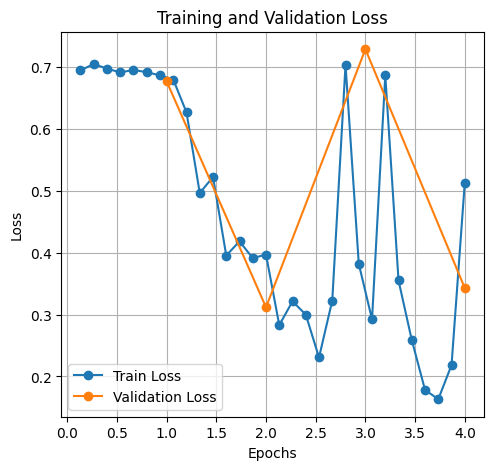

In [ ]:
import matplotlib.pyplot as plt

# Get the training logs
train_logs = trainer.state.log_history

# Extract relevant metrics
train_epochs = [log['epoch'] for log in train_logs if 'loss' in log]
train_loss = [log['loss'] for log in train_logs if 'loss' in log]

# Extract validation logs (assuming 'eval_loss' and 'eval_accuracy' are recorded in the same log entries)
eval_epochs = [log['epoch'] for log in train_logs if 'eval_loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

# Plot train loss across all training epochs
plt.plot(train_epochs, train_loss, label='Train Loss', marker='o')

# Plot validation loss at the epochs it was recorded
if eval_epochs and eval_loss:
    plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

'''
# Plotting validation accuracy
plt.subplot(1, 2, 2)
# Check if both eval_epochs and eval_accuracy exist before plotting
if eval_epochs and eval_accuracy:
    plt.plot(eval_epochs, eval_accuracy, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
'''

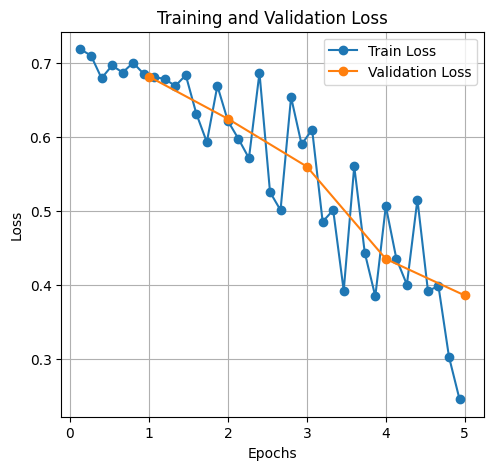

              precision    recall  f1-score   support

    Truthful       0.91      0.86      0.89       100
   Deceptive       0.87      0.92      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Accuracy: 0.89

 Precision: 0.8679245283018868

 Recall: 0.92

 f1-score: 0.8932038834951457 

Confusion matrix: [[92  8]
 [14 86]]
Mathews Correlation: 0.7814078022083395


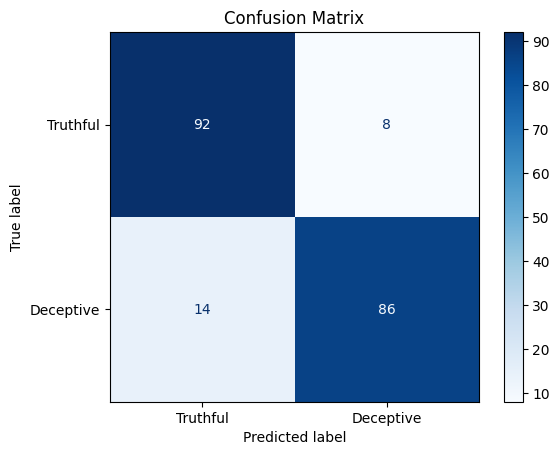

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the classification report
report = classification_report(test_df['review_type'], test_df['predicted_review_type'], target_names=['Truthful', 'Deceptive'])
print(report)

t_df = test_df['predicted_label'].map({0: 'truthful', 1: 'deceptive'})

print(f"Accuracy: {accuracy_score(test_df['review_type'], test_df['predicted_review_type'])}")
print(f"\n Precision: {precision_score(test_df['review_type'], test_df['predicted_review_type'],pos_label='truthful')}")
print(f"\n Recall: {recall_score(test_df['review_type'], test_df['predicted_review_type'],pos_label='truthful')}")
print(f"\n f1-score: {f1_score(test_df['review_type'], test_df['predicted_review_type'],pos_label='truthful')} \n")

# Generate the confusion matrix
cm = confusion_matrix(test_df['review_type'], test_df['predicted_review_type'], labels=['truthful', 'deceptive'])
print(f"Confusion matrix: {cm}")

print(f"Mathews Correlation: {matthews_corrcoef(test_df['review_type'], test_df['predicted_review_type'])}")

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Truthful', 'Deceptive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

 Area UC: 0.9549999999999998


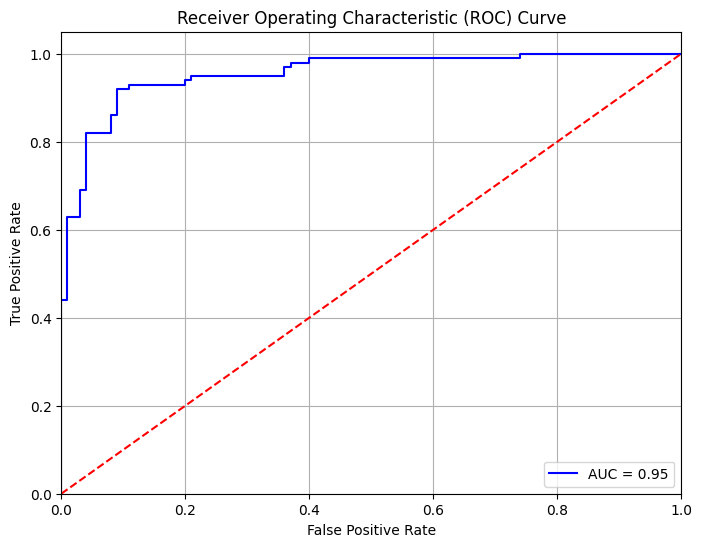

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the probabilities of the positive class
probabilities = predictions.predictions[:, 1]  # Assuming class 1 is 'deceptive'

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities, pos_label=1)
roc_auc = auc(fpr, tpr)

print(f" Area UC: {metrics.auc(fpr, tpr)}")

# Plotting the AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()